In [2]:
!pip install folium
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from IPython.display import HTML

import pandas as pd
import numpy as np
import folium
import requests

import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

     |████████████████████████████████| 92kB 13.7MB/s eta 0:00:01


## 1. Collecting Population Density Data for US Cities

In [3]:
website_url = requests.get('https://www.governing.com/gov-data/population-density-land-area-cities-map.html').text

In [4]:
# get the table
soup = BeautifulSoup(website_url,'lxml')
my_table = soup.find("table", { "class":"dataTable"})

In [5]:
# Function: Convert BeautifulSoup tags to string list
def convert_to_list(bs4row):
    list_bs4row = bs4row.findAll(["td","th"])
    return [bs4.get_text().strip() for bs4 in list_bs4row]

In [6]:
# get the table
soup = BeautifulSoup(website_url,'lxml')
my_table = soup.find("table", { "class":"dataTable"})
rows=my_table.findAll("tr")

# convert to list of list
my_data = [convert_to_list(r) for r in rows[1:]]

### The Population Density Dataframe

In [7]:
df = pd.DataFrame(my_data,columns=['City','Population_Density','Population','Land_Area'])

# convert the number from string to integer
for col in df.columns[1:]:
    df[col]=df[col].apply(lambda s: int(s.replace(',','')))

print('Number of US city: {}'.format(len(df)))

Number of US city: 754


In [8]:
df.head()

,City,Population_Density,Population,Land_Area
0,"New York, New York",28211,8537673,303
1,"Los Angeles, California",8484,3976322,469
2,"Chicago, Illinois",11883,2704958,228
3,"Houston, Texas",3842,2303482,600
4,"Phoenix, Arizona",3126,1615017,517


In [9]:
df.describe()

,Population_Density,Population,Land_Area
count,754.000000,7.540000e+02,754.000000
mean,4242.729443,1.646172e+05,55.015915
std,4323.792554,3.973563e+05,95.695024
min,172.000000,5.007700e+04,1.000000
25%,2076.000000,6.417050e+04,19.000000
50%,3128.500000,8.669450e+04,31.500000
75%,4720.000000,1.380125e+05,54.750000
max,54138.000000,8.537673e+06,1705.000000


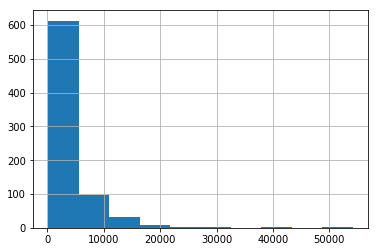

In [10]:
# Plot histogram of population density
df['Population_Density'].hist(bins=10)

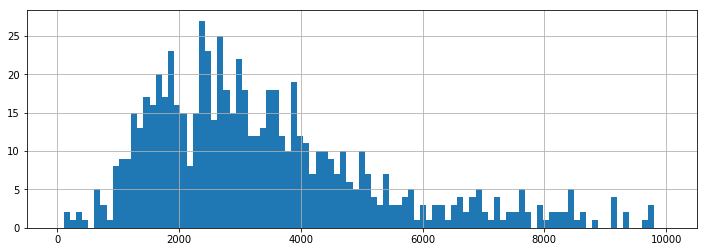

In [11]:
# Histogram of city with density less than 10,000
df['Population_Density'].hist(bins=np.linspace(0,10000,100),figsize=[12,4])

### Obtaining Long/Lat Cooordinates of the cities

In [12]:
def get_latitude_longitude(city):
    geolocator = Nominatim(user_agent="my-application")
    try:
        location = geolocator.geocode(city)
        if location is not None:
            return location.latitude, location.longitude
        else:
            return np.NaN,np.NaN
    except GeocoderTimedOut:
        return get_latitude_longitude(city)

In [13]:
# Get the latitude and longitude for each city
df['Latitude'],df['Longitude'] = zip(*df['City'].apply(get_latitude_longitude))

In [14]:
# Remove city without latitude and longitude
df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# 2. Plotting the Population Density of Cities

In [15]:
# create map
US_lat, US_long = get_latitude_longitude('US')
map_US = folium.Map(location=[US_lat,US_long], zoom_start=4)

In [16]:
# set color scheme
cmap = plt.cm.get_cmap('YlOrRd')
norm = colors.LogNorm(vmin=df['Population_Density'].min(), vmax=df['Population_Density'].max())

In [17]:
# add markers to the map
markers_colors = []
for lat, lon, poi, den in zip(df['Latitude'], df['Longitude'], df['City'], df['Population_Density']):
    label = folium.Popup(str(poi) + '\nDensity:' + str(den), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors.rgb2hex(cmap(norm(den))),
        fill_color=colors.rgb2hex(cmap(norm(den))),
        weight=1,
        opacity=0.3,
        fill_opacity=0.3).add_to(map_US)
map_US

# Collecting the neighbours using foursquare API

In [18]:
# The code was removed by Watson Studio for sharing.

### COllecting nearby venues

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
df_city_venues = getNearbyVenues(df['City'],df['Latitude'],df['Longitude'])


### Calculating the frequency of venues for each city

In [22]:
df_density = df[['City','Population_Density']]

In [23]:
# one hot encoding
df_onehot = pd.get_dummies(df_city_venues[['Venue Category']], prefix="", prefix_sep="")
df_onehot['City'] = df_city_venues['City']
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]
df_venues_freq_by_city = df_onehot.groupby('City').mean()

df_venues_freq_by_city_density = pd.merge(df_venues_freq_by_city, df_density, on=['City'], how='left')
df_venues_freq_by_city_density.head()

,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo,Population_Density
0,"Abilene, Texas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,...,0.000000,0.035714,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1145
1,"Akron, Ohio",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,...,0.013158,0.013158,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,3186
2,"Albany, Georgia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,...,0.000000,0.000000,0.000000,0.0,0.037037,0.0,0.0,0.0,0.0,1339
3,"Albany, New York",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044944,...,0.000000,0.000000,0.011236,0.0,0.000000,0.0,0.0,0.0,0.0,4587
4,"Albany, Oregon",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.037037,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,3034


# Coorelation between venue's composition & Population Density

In [24]:
df_corr = pd.DataFrame(df_venues_freq_by_city_density.corr()['Population_Density'])

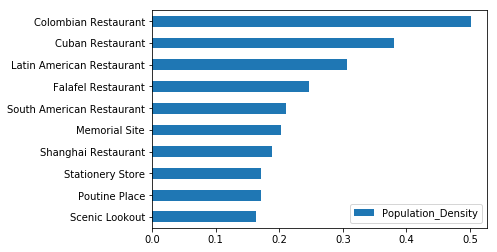

In [25]:
df_corr = df_corr.head(len(df_corr)-1).sort_values(['Population_Density'])
df_corr.tail(10).plot.barh()

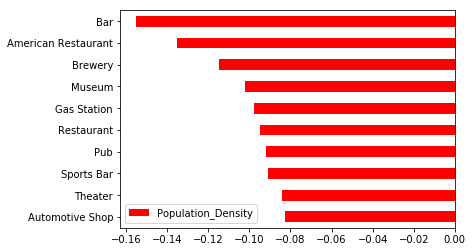

In [26]:
df_corr = df_corr.head(len(df_corr)-1).sort_values(['Population_Density'],ascending=False)
df_corr.tail(10).plot.barh(color='r')

# Predicting Population Density with ML Approaches

In [30]:
def set_density_class(density):
    if density > 6000:
        return 1
    elif density < 2000:
        return 0
    else:
        return np.NaN

In [31]:
df['Density_class'] = df['Population_Density'].apply(set_density_class)
df_class = df[['City','Density_class']]

In [32]:
df_class = df[['City','Density_class']]

In [33]:
df_venues_freq_by_city_density_class = pd.merge(df_venues_freq_by_city, df_class, on=['City'], how='inner')
df_venues_freq_by_city_density_class.dropna(subset=['Density_class'],inplace=True)
df_venues_freq_by_city_density_class.shape

(300, 540)

In [34]:
features = df_venues_freq_by_city_density_class.columns[1:-1]

In [35]:
df_venues_freq_by_city_density_class.head()

,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo,Density_class
0,"Abilene, Texas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,...,0.0,0.035714,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0
2,"Albany, Georgia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,...,0.0,0.000000,0.0,0.0,0.037037,0.0,0.0000,0.0,0.0,0.0
6,"Alexandria, Virginia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,1.0
7,"Alhambra, California",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.013889,0.0,0.0,0.027778,0.0,0.0000,0.0,0.0,1.0
8,"Aliso Viejo, California",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0125,0.0,0.0,1.0
